<a href="https://colab.research.google.com/github/kelvin-kiplagat/Clinical-Trials-Analysis/blob/main/clinical_trials_analysis_complete_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from functools import reduce

# Stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import scipy.stats as st
from imblearn.under_sampling import RandomUnderSampler

# ML
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from sklearn.model_selection import train_test_split

nltk.download('punkt')
plt.style.use("seaborn-v0_8-bright")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Mount Drive**

In [2]:
from google.colab import drive
drive.mount("drive")

Mounted at drive


**Datasets**
- Full paths to the datasets

In [3]:
access_path = './drive/MyDrive/Datathon/Phase II/Data'

In [4]:
# Read in the dataframes
cancer_df, covid_df, heart_df, hiv_df, malaria_df, pneumonia_df = [pd.read_csv(access_path + f"/{fname}") for fname in os.listdir(access_path)]

datasets = [cancer_df, covid_df, heart_df, hiv_df, malaria_df, pneumonia_df]
study_areas = ["cancer", "covid", "heart", "HIV", "malaria", "pneumonia"]
cols_to_drop = ['nct_number', 'study_title', 'study_url', 'acronym', 'brief_summary', 'other_ids', 'study_documents'] #'secondary_outcome_measures', 'primary_outcome_measures'


# process the column names, drop unnecessary columns, and merge the dataframes into one big dataframe
clinical_df = pd.DataFrame()
for i in range(len(datasets)):
    df = datasets[i]
    disease_of_interest = study_areas[i]
    df.columns = [col.lower().replace(" ","_") for col in df.columns]
    df_ = df.drop(columns = cols_to_drop)
    df_['study_area'] = disease_of_interest
    clinical_df = pd.concat([clinical_df, df_], axis = 0, ignore_index = True)
print("Original Number of Observations: ",clinical_df.shape[0])

# Drop rows that do not have a start date
print(f"Number of trials with no start date: {clinical_df.start_date.isna().sum()}")
clinical_df = clinical_df.loc[clinical_df.start_date.notna(), :]
# Preprocess date columns
date_columns = ["start_date", "primary_completion_date", "completion_date", "first_posted", "results_first_posted", "last_update_posted"]
clinical_df[date_columns] = reduce(lambda x, y : pd.concat([x, y], axis = 1), [pd.to_datetime(clinical_df[col], format = "%Y-%m-%d", errors = "coerce") for col in date_columns])
clinical_df['start_year'] = clinical_df.start_date.apply(lambda x : x.year)
clinical_df = clinical_df.loc[clinical_df.start_year < 2024, :] # Filter out any clinical trial that has not started
clinical_df['days_to_completion'] = (clinical_df.completion_date - clinical_df.start_date).apply(lambda x : x.days) # Compute days to completion

# Extract the Masking Type and Intervention Model
def extract_model(text):
    if type(text) != float: # Unpopular way of eliminating NaNs
        if "Intervention" in text:
            texts = text.split("|")
            intervention_model = texts[1].split(": ")[1]
            return (intervention_model)
        return np.nan
    return np.nan

def extract_masking(text):
    if type(text) != float: # Unpopular way of eliminating NaNs
        if "Intervention" in text:
            texts = text.split("|")
            masking = texts[2].split(" ")[1]
            return (masking)
        return np.nan
    return np.nan

# Add those columns
clinical_df["intervention_model"] = clinical_df.study_design.apply(extract_model)
clinical_df["masking"] = clinical_df.study_design.apply(extract_masking)
clinical_df["has_collaborators"] =  clinical_df.collaborators.apply(lambda x: 0 if pd.isnull(x)  else 1) # 0 if no collaborators else 1
clinical_df["interventions_count"] = clinical_df.interventions.apply(lambda x: 0 if pd.isnull(x)  else len(x.split("|")))
clinical_df["all_outcome_measures"] = (clinical_df["primary_outcome_measures"].replace(np.nan, "") + " " + # Merge all the outcome measures into 1
                                       clinical_df["secondary_outcome_measures"].replace(np.nan, "") + " " +
                                       clinical_df["other_outcome_measures"].replace(np.nan, ""))
clinical_df = clinical_df.drop(columns = ['secondary_outcome_measures', 'primary_outcome_measures', 'other_outcome_measures'])

print("Total Number of Observations: ",clinical_df.shape[0])
print(clinical_df.info())
clinical_df.sample(5)

Original Number of Observations:  161863
Number of trials with no start date: 2356
Total Number of Observations:  159008
<class 'pandas.core.frame.DataFrame'>
Int64Index: 159008 entries, 0 to 161862
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   study_status             159008 non-null  object        
 1   study_results            159008 non-null  object        
 2   conditions               159006 non-null  object        
 3   interventions            141952 non-null  object        
 4   sponsor                  159008 non-null  object        
 5   collaborators            60055 non-null   object        
 6   sex                      158872 non-null  object        
 7   age                      159008 non-null  object        
 8   phases                   79909 non-null   object        
 9   enrollment               156568 non-null  float64       
 10  funder_type        

,study_status,study_results,conditions,interventions,sponsor,collaborators,sex,age,phases,enrollment,...,last_update_posted,locations,study_area,start_year,days_to_completion,intervention_model,masking,has_collaborators,interventions_count,all_outcome_measures
136354,UNKNOWN,NO,Coronary Disease,PROCEDURE: Coronary Angiography and Intervention,Beijing Anzhen Hospital,NaN,ALL,"ADULT, OLDER_ADULT",NaN,938.0,...,2021-04-13,NaN,heart,2021,296.0,PARALLEL,NONE,0,1,"Radial artery occlusion, Doppler Ultrasonograp..."
150896,UNKNOWN,NO,Malaria,DRUG: Fosmidomycin|DRUG: Azithromycin,Jomaa Pharma GmbH,Mahidol University|Thammasat University,ALL,"CHILD, ADULT",PHASE2,43.0,...,2011-11-03,"Mahidol University, Bangkok, 10400, Thailand",malaria,2008,1125.0,SINGLE_GROUP,NONE,1,2,"day 28 cure rate of >95%, Efficacy of fosmidom..."
27307,RECRUITING,NO,Breast Cancer,BEHAVIORAL: Multicomponent Adherence Intervent...,Columbia University,National Institute on Minority Health and Heal...,ALL,"ADULT, OLDER_ADULT",NaN,350.0,...,2023-07-21,"Columbia University Medical Center, New York, ...",cancer,2023,1490.0,SINGLE_GROUP,NONE,1,2,Number of Participants Adherent to Endocrine T...
11723,WITHDRAWN,NO,Kidney Neoplasms,DRUG: 18F-Fluciclatide,National Cancer Institute (NCI),NaN,ALL,"ADULT, OLDER_ADULT",PHASE1|PHASE2,0.0,...,2019-12-17,NaN,cancer,2012,735.0,SINGLE_GROUP,NONE,0,1,To determine tumor uptake and retention of [18...
94988,RECRUITING,NO,Brain Neoplasm|Low Grade Glioma|Seizure Disorder,OTHER: Survey Administration,M.D. Anderson Cancer Center,National Cancer Institute (NCI),ALL,"CHILD, ADULT, OLDER_ADULT",NaN,100.0,...,2023-06-06,"M D Anderson Cancer Center, Houston, Texas, 77...",cancer,2020,1270.0,NaN,NaN,1,1,"Rate of change of seizure frequency, Both aver..."


## **Clinical Trials with No Enrollment Data**

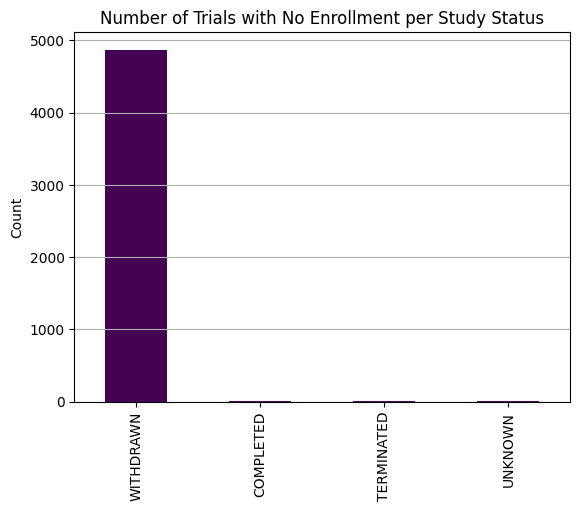


Complete Clinical Trials Data with No Enrollment


,sponsor,study_results,study_area,start_date,completion_date,funder_type
110182,ViiV Healthcare,NO,heart,2009-03-01,2010-12-01,INDUSTRY
128145,"National Heart, Lung, and Blood Institute (NHLBI)",NO,heart,2007-01-11,2007-12-10,NIH
141951,ViiV Healthcare,NO,HIV,2009-03-01,2010-12-01,INDUSTRY
144401,National Institute of Allergy and Infectious D...,NO,HIV,2006-02-16,2007-11-15,NIH
147761,National Institute of Environmental Health Sci...,NO,HIV,2004-06-25,2007-12-28,NIH
151090,National Institute of Allergy and Infectious D...,NO,malaria,2004-06-09,2008-02-06,NIH
152129,National Institute of Allergy and Infectious D...,NO,malaria,2005-03-07,2008-06-17,NIH
152153,National Institute of Allergy and Infectious D...,NO,malaria,2005-03-08,2008-07-02,NIH
156975,National Institutes of Health Clinical Center ...,NO,pneumonia,2006-08-11,2007-05-22,NIH


In [5]:
no_enroll = clinical_df[clinical_df.enrollment == 0]
# Bar Plot per Study Status
no_enroll.study_status.value_counts().plot(kind = "bar", cmap = "viridis")
plt.title("Number of Trials with No Enrollment per Study Status")
plt.ylabel("Count")
plt.grid(axis = "y")
plt.show()

# Interested in the "COMPLETED" with no enrollment
print("\n================================================\nComplete Clinical Trials Data with No Enrollment\n================================================")
no_enroll.loc[no_enroll.study_status == "COMPLETED", ["sponsor", "study_results", "study_area", "start_date", "completion_date", "funder_type"]]

### Enrollment Numbers Over Time
- Eliminating Observations with no Enrollment Data

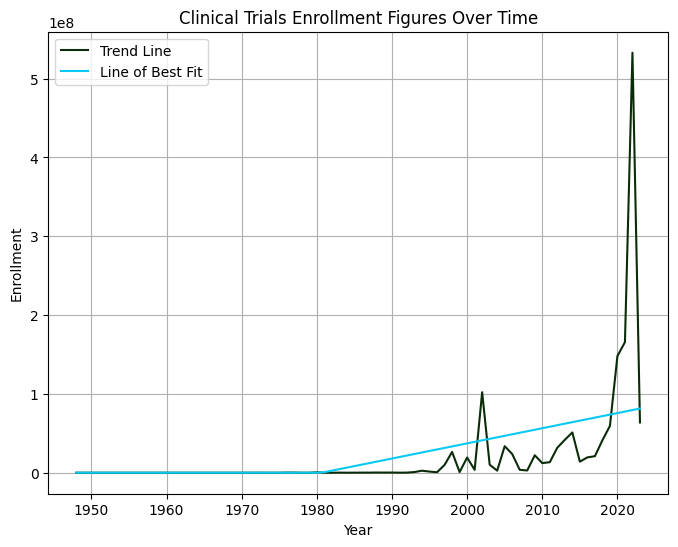

In [6]:
# Eliminating Observations with no Enrollment Data
clinical_df = clinical_df.loc[clinical_df.enrollment != 0, :]

# Clinical enrollment data over time
enrollment_over_time = clinical_df.groupby('start_year').enrollment.sum()
t = np.arange(1, enrollment_over_time.shape[0]+1, 1)
a, b = np.polyfit(t, enrollment_over_time.tolist(), 1)
lbf = np.where((a*t + b) < 0, 0, (a*t + b)) # Line of best fit, # We can't have non-zero clinical trials
enrollment_over_time.plot(kind = 'line', figsize = (8, 6), color = '#0A2C08', label = "Trend Line")
plt.plot(enrollment_over_time.index, lbf, label = "Line of Best Fit", color = "#08CAF1")
plt.title("Clinical Trials Enrollment Figures Over Time")
plt.xlabel("Year")
plt.ylabel("Enrollment")
plt.legend()
plt.grid()
plt.show()


## **Descriptive Statistics of the Numeric Data**

In [7]:
clinical_df._get_numeric_data().drop(columns = ['start_year', 'has_collaborators']).describe()

,enrollment,days_to_completion,interventions_count
count,1.516770e+05,148856.000000,154117.000000
mean,9.784273e+03,1406.555725,1.797180
std,7.857562e+05,1378.653167,1.702755
min,1.000000e+00,0.000000,0.000000
25%,3.300000e+01,549.000000,1.000000
50%,8.000000e+01,1078.000000,1.000000
75%,2.480000e+02,1826.000000,2.000000
max,1.888141e+08,40177.000000,57.000000


### **Insights - Anomalies**

- The mean enrollment is way greater than the 75th Percentile. The data is heavily right skewed.
- Maximum days taken by clinical study is 40177days (roughly 110 years)
- For any analysis, we will have to omit those outliers but before, ommision, let's find out what about them

#### **Outlier Clinical Trials in Terms of Enrollment and Days to Completion**

Number of Clinical Trials Taking longer than usual: 25164


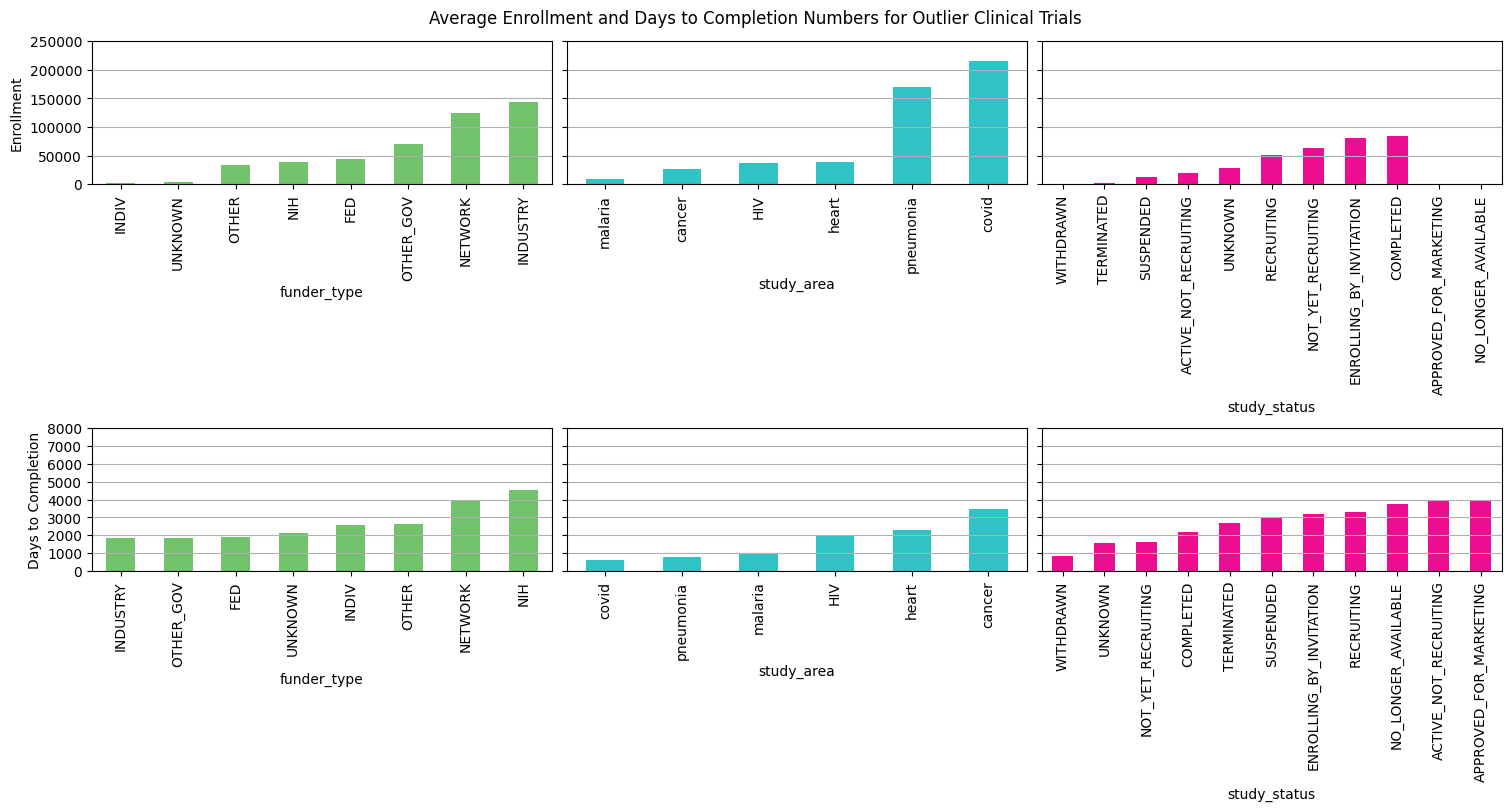

In [8]:
# Investigate trials whose days to completion are beyond outlier range
Q3_dtc, Q3_enrl = clinical_df.days_to_completion.quantile(0.75), clinical_df.enrollment.quantile(0.75)
IQR_dtc = Q3_dtc - clinical_df.days_to_completion.quantile(0.25)
IQR_enrl = Q3_enrl - clinical_df.enrollment.quantile(0.25)

outlier_trials = clinical_df.loc[
    (clinical_df.days_to_completion >= Q3_dtc + 1.5*IQR_dtc) | (clinical_df.enrollment >= Q3_enrl + 1.5*IQR_enrl ),
    ["sponsor", "funder_type", "study_area", "study_status", "enrollment", "start_date", "completion_date", "days_to_completion"]
]
print("Number of Clinical Trials Taking longer than usual:",outlier_trials.shape[0])

funder_group = outlier_trials.groupby("funder_type")
study_area_group = outlier_trials.groupby("study_area")
study_status_group = outlier_trials.groupby("study_status")

# Visualize a few things to get the overall idea
fig, ax = plt.subplots(nrows = 2, ncols = 3, constrained_layout = True, figsize = (15, 8), sharey = 'row')
# Funder group
funder_group["enrollment"].mean().sort_values().plot(kind = "bar", ax =  ax[0,0], color = "#71C26A")
funder_group["days_to_completion"].mean().sort_values().plot(kind = "bar", ax =  ax[1,0], color = "#71C26A")
# Study area
study_area_group["enrollment"].mean().sort_values().plot(kind = "bar", ax =  ax[0,1], color = "#2FC3C6")
study_area_group["days_to_completion"].mean().sort_values().plot(kind = "bar", ax =  ax[1,1], color = "#2FC3C6")
# Study status
study_status_group["enrollment"].mean().sort_values().plot(kind = "bar", ax =  ax[0,2], color = "#EC0D91")
study_status_group["days_to_completion"].mean().sort_values().plot(kind = "bar", ax =  ax[1,2], color = "#EC0D91")
ax[0,0].set_ylabel("Enrollment")
ax[0,0].set_yticks(range(0, 250001, 50000), range(0, 250001, 50000))
ax[1,0].set_ylabel("Days to Completion")
ax[1,0].set_yticks(range(0, 8001, 1000), range(0, 8001, 1000))
for a_x in ax.flat:
    a_x.grid(True, axis = "y")
fig.suptitle("Average Enrollment and Days to Completion Numbers for Outlier Clinical Trials", fontweight = 20)
plt.show()

#### **Normal Data - Clinical Trials Inside the Outlier Upper Threshold**

In [9]:
clinical_trials = clinical_df.loc[
    ((clinical_df.days_to_completion < Q3_dtc + 1.5*IQR_dtc) & (clinical_df.enrollment < Q3_enrl + 1.5*IQR_enrl ))
]
clinical_trials.shape

(122678, 28)

## **Distribution of the numerical features**

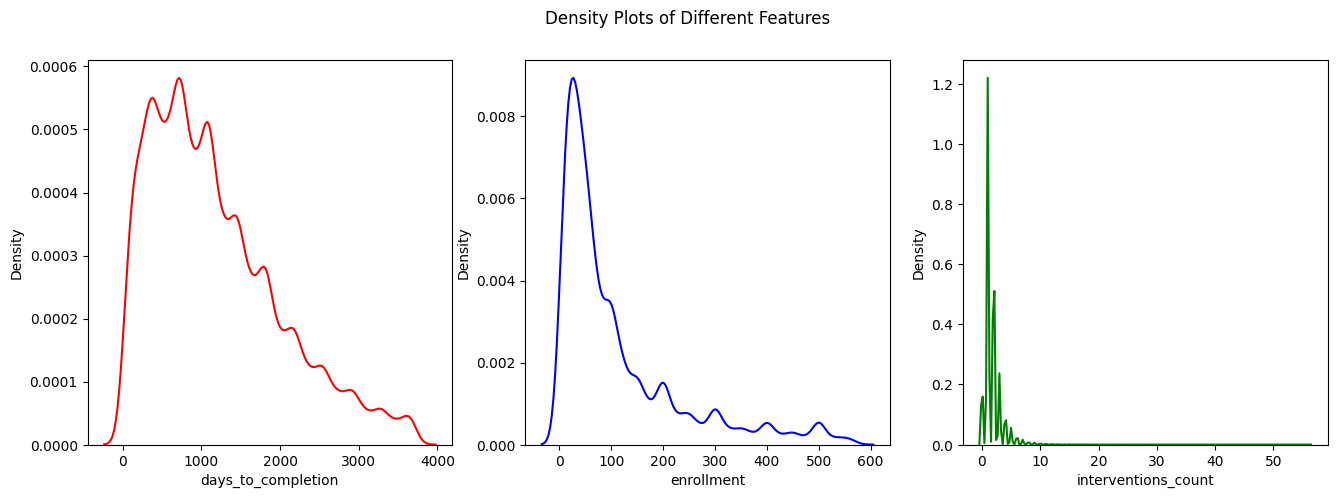

In [10]:
fig, axs = plt.subplots(ncols = 3, figsize = (16, 5))

sns.kdeplot(x = "days_to_completion", data = clinical_trials, ax = axs[0], color = "Red")
sns.kdeplot(data = clinical_trials, x = 'enrollment', ax = axs[1], color = "Blue")
sns.kdeplot(data = clinical_trials, x = 'interventions_count', ax = axs[2], color = "green")
fig.suptitle("Density Plots of Different Features")
plt.show()

**Outliers will not be removed**

In [11]:
clinical_trials = clinical_df.copy()

#### Average Number of Days Taken by Each Study Area Clinical Trials

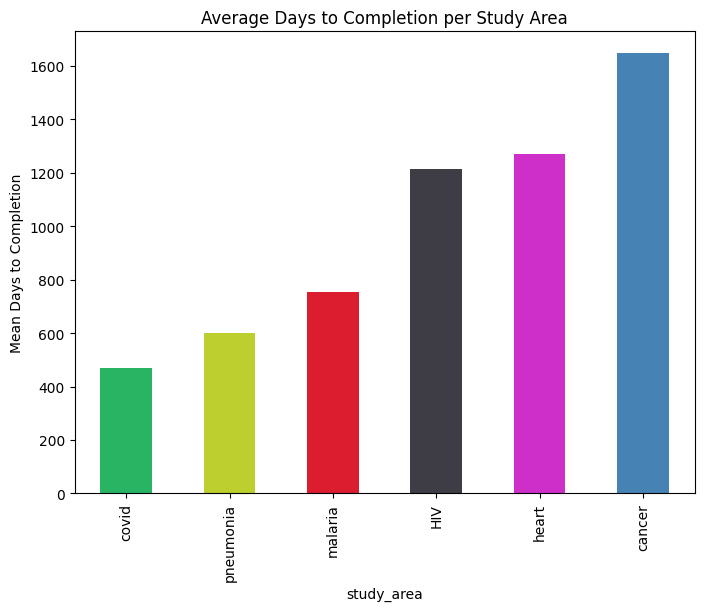

In [12]:
clinical_trials.groupby('study_area')['days_to_completion'].mean().sort_values().plot(
    kind = 'bar', figsize = (8,6), color = ["#28B463", "#BDCE2F", "#DB1D2F", "#3E3C45", "#CE2FC9", "steelblue"])
plt.title("Average Days to Completion per Study Area")
plt.ylabel("Mean Days to Completion")
plt.show()

Text(0.5, 1.0, 'Days to Completion by Gender')

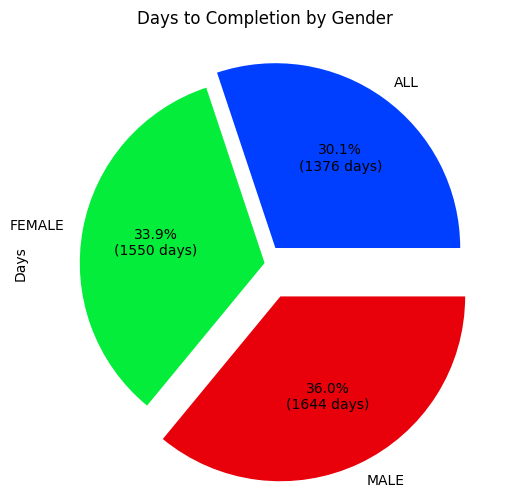

In [13]:
data_trials = clinical_trials.groupby('sex').days_to_completion.mean()
def func(pct, data):
    ab = int(np.round(pct/100.*np.sum(data)))
    return f"{pct:.1f}%\n({ab:d} days)"
data_trials.plot(
    kind = "pie", explode = [0.1, 0, 0.2], figsize = (6,6), label = 'Days', autopct = lambda x: func(x, data_trials)
)
plt.title("Days to Completion by Gender")

In [14]:
clinical_trials.columns

Index(['study_status', 'study_results', 'conditions', 'interventions',
       'sponsor', 'collaborators', 'sex', 'age', 'phases', 'enrollment',
       'funder_type', 'study_type', 'study_design', 'start_date',
       'primary_completion_date', 'completion_date', 'first_posted',
       'results_first_posted', 'last_update_posted', 'locations', 'study_area',
       'start_year', 'days_to_completion', 'intervention_model', 'masking',
       'has_collaborators', 'interventions_count', 'all_outcome_measures'],
      dtype='object')

In [15]:
# Under sampling may be needed for contingency tables to balance sample sizes
def under_sample(df, balance_column, categories_keep):
    df1 = df.copy() # Create a copy to avoid messing the original dataframe
    df1 = df1.loc[df1[balance_column].isin(categories_keep)] # Categories you don't want to eliminate
    under_sampler = RandomUnderSampler(sampling_strategy = 'auto', random_state = 107)
    x_resampled, y_resampled = under_sampler.fit_resample(df1.drop(columns = balance_column), df1[balance_column])
    balanced_df = x_resampled.reset_index(drop = True)
    balanced_df[balance_column] = y_resampled.to_numpy()
    return balanced_df


### Features of Interest
1. study status
2. study results
3. sex
4. age
5. phases
6. enrollment
7. study area (disease)
8. start year
9. days to completion
10. intervention model
11. Masking
12. has collaborator
13. Inteventions count

### Questions
1. Are there masking types common in different study areas than others?
2. a) Are there differences in the number of collaborators different study areas get? b) Does availability of collaborators affect study status in completed and terminated, and suspended studies?
3. Does the number of interventions differ in different study areas?
4. Are there differences in enrollment across sex and age?
5. Does the Funder type affect the study status?
6. Are there differences in interventions used in masking types categories?

### **1.Do different study areas prefer different masking types in interventions?**

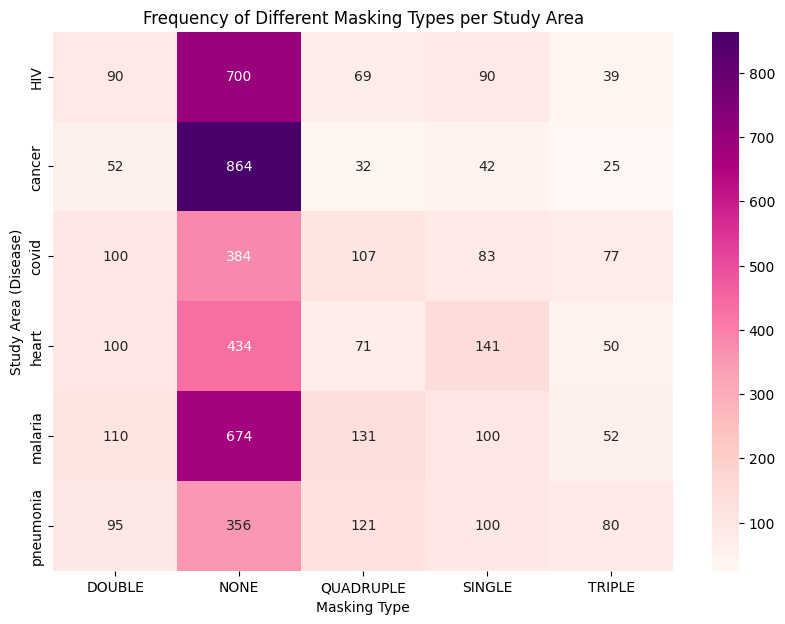


=========CHI^2 TEST RESULTS============
	F(20) = 458.95, p = 0.0000



In [16]:
# Frequency of masking types under different study areas
sample_si = under_sample(clinical_df, 'study_area', clinical_df.study_area.unique())
masking_study_area = pd.crosstab(sample_si['study_area'], sample_si['masking'], margins = False)
masking_study_area = masking_study_area.loc[:, ~masking_study_area.columns.isin([""])]
fig, ax = plt.subplots(figsize = (10,7))
sns.heatmap(masking_study_area, annot = True, ax = ax, cmap = "RdPu", fmt = "g")
plt.title("Frequency of Different Masking Types per Study Area")
plt.xlabel("Masking Type"), plt.ylabel("Study Area (Disease)")
plt.show()

# Chi Square Test
def chi_2(ct_table):
    stat, p, dof, expected = st.chi2_contingency(ct_table)
    print(f"\n=========CHI^2 TEST RESULTS============\n\tF({dof}) = {stat:.2f}, p = {p:.4f}\n=======================================\n")
chi_2(masking_study_area)

### **2. a) Are there differences in the number of collaborators different study areas get? b) Does availability of collaborators affect study status in completed and terminated, and suspended studies?**

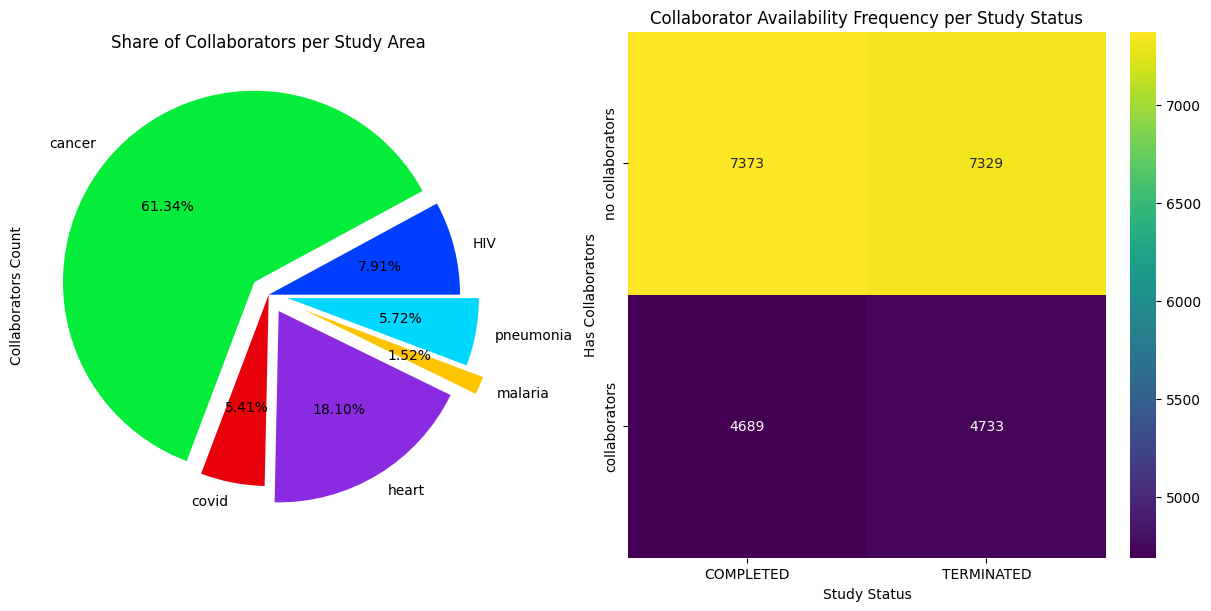


=========CHI^2 TEST RESULTS============
	F(1) = 0.32, p = 0.5704



In [17]:
# Use pie chart to answer the first question
# Use the whole dataframe as outliers doesn't affect it
# Number of collaborators per study area
fig, axs = plt.subplots(ncols = 2, figsize = (12, 6), constrained_layout = True)
clinical_df.groupby("study_area")['has_collaborators'].sum().plot(
    kind = "pie",
    explode = [0, 0.1, 0, 0.1, 0.2, 0.1],
    label = "Collaborators Count",
    autopct = "%.2f%%", ax = axs[0])
axs[0].set_title("Share of Collaborators per Study Area")

# Collaborator availability per study status, UNDERSAMPLE COMPLETED
sample_sh = under_sample(clinical_df, 'study_status', ['COMPLETED', 'TERMINATED'])
collab_study_status = pd.crosstab(sample_sh['has_collaborators'], sample_sh['study_status'], margins = False)
collab_study_status.index = ["no collaborators", "collaborators"]

sns.heatmap(collab_study_status, annot = True, cmap = "viridis", fmt = "g", ax = axs[1])
axs[1].set_title("Collaborator Availability Frequency per Study Status")
axs[1].set_ylabel("Has Collaborators"), axs[1].set_xlabel("Study Status")
plt.show()

# Chi Square Test
chi_2(collab_study_status)




### **3. Does the number of interventions differ in different study areas?**

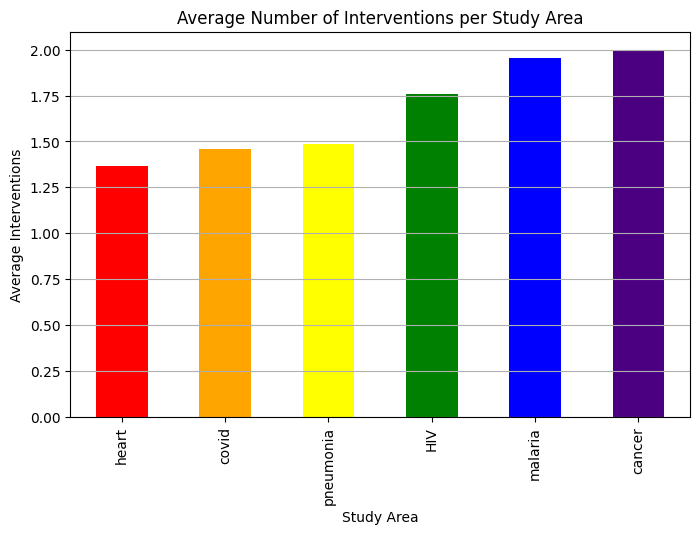


ANOVA - ONE WAY
-------------------
                      sum_sq        df           F  PR(>F)
C(study_area)   11565.436786       5.0  818.958946     0.0
Residual       435274.817670  154111.0         NaN     NaN

Post-Hoc Test
----------------
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
    HIV    cancer   0.2377    0.0  0.1812  0.2942   True
    HIV     covid  -0.3028    0.0 -0.3771 -0.2284   True
    HIV     heart  -0.3925    0.0 -0.4533 -0.3317   True
    HIV   malaria   0.1918 0.0021  0.0475   0.336   True
    HIV pneumonia  -0.2769    0.0 -0.3507  -0.203   True
 cancer     covid  -0.5404    0.0 -0.5934 -0.4874   True
 cancer     heart  -0.6302    0.0 -0.6615 -0.5989   True
 cancer   malaria  -0.0459 0.9267 -0.1804  0.0886  False
 cancer pneumonia  -0.5145    0.0 -0.5669 -0.4622   True
  covid     heart  -0.0897 0.0001 -0.1473 -0.0322   True
  covid   mal

In [18]:
clinical_df.groupby(
    'study_area'
)['interventions_count'].mean().sort_values().plot(
    kind = "bar",
    color = "red, orange, yellow, green, blue, indigo".split(", "), # use first six rainbow colors
    figsize = (8,5)
)
plt.title("Average Number of Interventions per Study Area")
plt.ylabel("Average Interventions")
plt.xlabel("Study Area")
plt.grid(axis = 'y')
plt.show()

# Using One-Way ANOVA to compare if there are differences in means between the different study areas
model = ols('interventions_count ~ C(study_area)', data = clinical_df).fit()
aov_study_area = sm.stats.anova_lm(model, typ = 2)
print("\nANOVA - ONE WAY\n-------------------")
print(aov_study_area)

# Post HOC test to ascertain differences are in which groups
tukey_study_ic = pairwise_tukeyhsd(
    endog = clinical_df.interventions_count,
    groups = clinical_df.study_area,
    alpha = 0.05
)
print("\nPost-Hoc Test\n----------------")
print(tukey_study_ic)


### **4. Are there differences in enrollment across sex and age categories?**

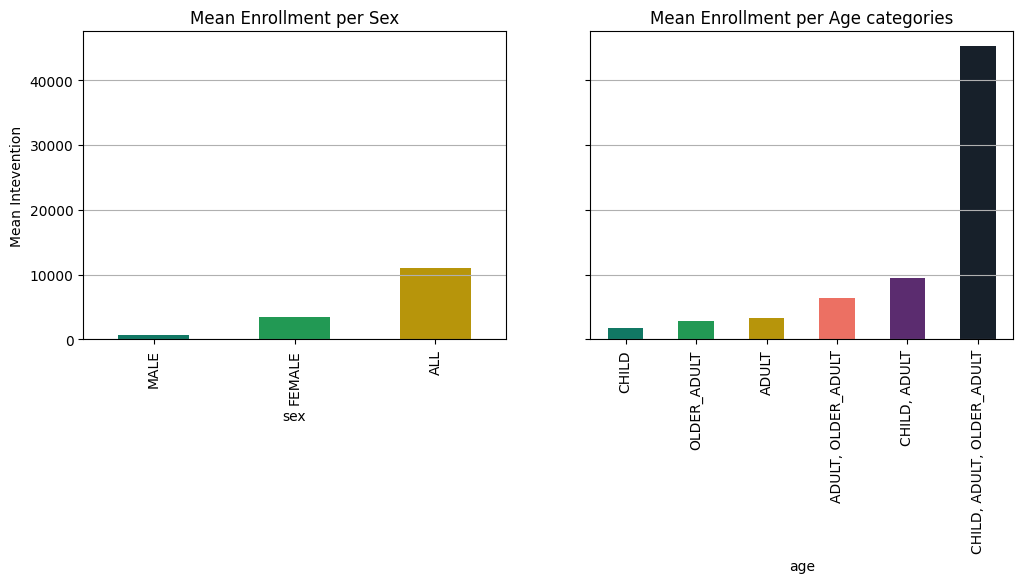




ANOVA - TWO WAY (Enrollment vs Age and Sex )
                     sum_sq        df         F    PR(>F)
C(sex)         1.149609e+12       2.0  0.930444  0.394381
C(age)         1.968707e+13       5.0  6.373547  0.000006
C(sex):C(age)  2.485531e+12      10.0  0.402336  0.946284
Residual       9.362311e+16  151549.0       NaN       NaN

Post-Hoc Test - Age
----------------
                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
          group1                    group2          meandiff p-adj lower upper reject
-------------------------------------------------------------------------------------
                    ADULT        ADULT, OLDER_ADULT      nan   nan   nan   nan  False
                    ADULT                     CHILD      nan   nan   nan   nan  False
                    ADULT              CHILD, ADULT      nan   nan   nan   nan  False
                    ADULT CHILD, ADULT, OLDER_ADULT      nan   nan   nan   nan  False
                    AD

In [19]:
age_sex = clinical_trials.loc[clinical_trials.sex.notna()]
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4), sharey = True)
age_sex.groupby('sex')[
    'enrollment'
].mean().sort_values().plot(
    kind = 'bar',
    color = '#117864,#229954,#B7950B,#EC7063,#5B2C6F,#17202A'.split(','),
    ax = ax1
)

age_sex.groupby('age')[
    'enrollment'
].mean().sort_values().plot(
    kind = 'bar',
    color = '#117864,#229954,#B7950B,#EC7063,#5B2C6F,#17202A'.split(','),
    ax = ax2
)

ax1.set_title("Mean Enrollment per Sex")
ax2.set_title("Mean Enrollment per Age categories")
ax1.set_ylabel("Mean Intevention")
ax1.grid(axis = 'y'), ax2.grid(axis = 'y')
plt.show()
print("\n\n")

age_sex_anova = ols('enrollment ~ C(sex) * C(age)', data = age_sex).fit()
age_sex_anova_model = sm.stats.anova_lm(age_sex_anova, typ = 2)
print("ANOVA - TWO WAY (Enrollment vs Age and Sex )")
print(age_sex_anova_model)

# Post HOC test to ascertain differences are in which groups
tukey_age = pairwise_tukeyhsd(
    endog = age_sex.enrollment,
    groups = age_sex.age,
    alpha = 0.05
)
print("\nPost-Hoc Test - Age\n----------------")
print(tukey_age)

tukey_sex = pairwise_tukeyhsd(
    endog = age_sex.enrollment,
    groups = age_sex.sex,
    alpha = 0.05
)
print("\nPost-Hoc Test - Sex\n----------------")
print(tukey_sex)


## **5. Does the Funder type affect the study status in completed and terminated trials?**

---




=========CHI^2 TEST RESULTS============
	F(14) = 36.44, p = 0.0009



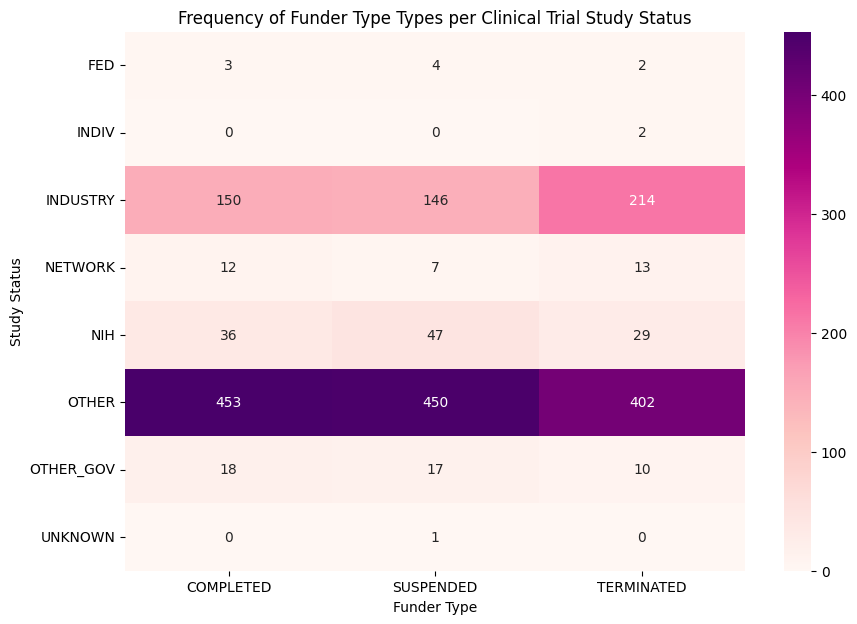

In [20]:
sample_fs = under_sample(clinical_df, 'study_status', ['COMPLETED', 'TERMINATED', 'SUSPENDED'])
study_funder = pd.crosstab(sample_fs['study_status'], sample_fs['funder_type'], margins = False).T

chi_2(study_funder)

fig, ax = plt.subplots(figsize = (10,7))
sns.heatmap(study_funder, annot = True, ax = ax, cmap = "RdPu", fmt = "g")
plt.title("Frequency of Funder Type Types per Clinical Trial Study Status")
plt.xlabel("Funder Type"), plt.ylabel("Study Status")
plt.show()

### **6. Are there differences in interventions used in intervention models categories?**

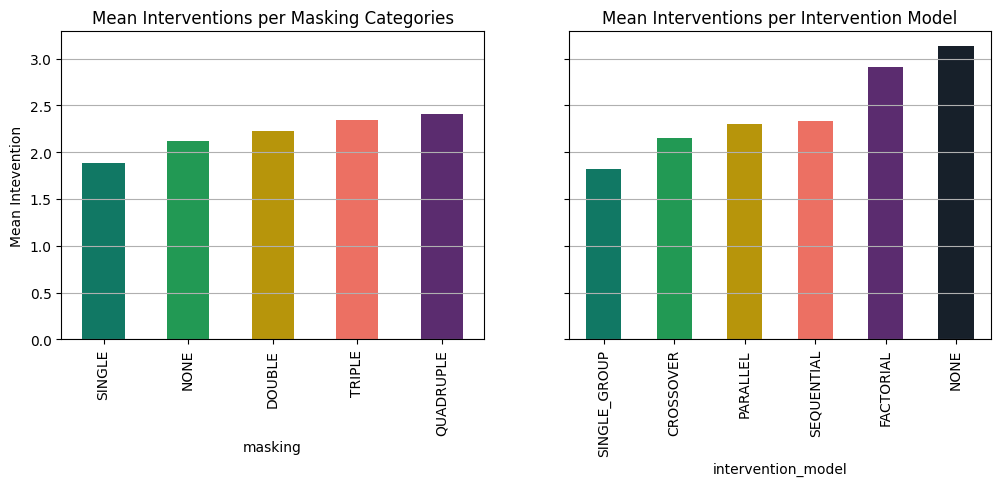




ANOVA - TWO WAY (Masking Intervention)


,sum_sq,df,F,PR(>F)
C(masking),1883.414058,4.0,162.549689,5.275200e-139
C(intervention_model),11035.670755,5.0,761.954534,0.000000e+00
C(masking):C(intervention_model),353.009026,20.0,6.093350,1.315702e-16
Residual,330965.320519,114257.0,NaN,NaN


In [21]:
df_sm = clinical_df[['masking', 'intervention_model', 'interventions_count']].dropna()
df_sm.masking[df_sm.masking == ""] = "NONE"
df_sm.intervention_model[df_sm.intervention_model == ""] = "NONE"

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4), sharey = True)
df_sm.groupby('masking')[
    'interventions_count'
].mean().sort_values().plot(
    kind = 'bar',
    color = '#117864,#229954,#B7950B,#EC7063,#5B2C6F,#17202A'.split(','),
    ax = ax1
)

df_sm.groupby('intervention_model')[
    'interventions_count'
].mean().sort_values().plot(
    kind = 'bar',
    color = '#117864,#229954,#B7950B,#EC7063,#5B2C6F,#17202A'.split(','),
    ax = ax2
)

ax1.set_title("Mean Interventions per Masking Categories")
ax2.set_title("Mean Interventions per Intervention Model")
ax1.set_ylabel("Mean Intevention")
ax1.grid(axis = 'y'), ax2.grid(axis = 'y')
plt.show()
print("\n\n")

# ANOVA - TWO WAY
print("ANOVA - TWO WAY (Masking Intervention)")
sm_anova = ols('interventions_count ~ C(masking) * C(intervention_model)', data = df_sm).fit()
aov_sm_anova = sm.stats.anova_lm(sm_anova, typ = 2)

# Post HOC test to ascertain differences are in which groups
tukey_im = pairwise_tukeyhsd(
    endog = df_sm.interventions_count,
    groups = df_sm.masking,
    alpha = 0.05
)

# Post HOC test to ascertain differences are in which groups
tukey_ii = pairwise_tukeyhsd(
    endog = df_sm.interventions_count,
    groups = df_sm.intervention_model,
    alpha = 0.05
)

aov_sm_anova

In [22]:

print("\nPost-Hoc Test - Masking Group\n----------------")
print(tukey_im)

print("\nPost-Hoc Test - Intervention Model\n----------------")
print(tukey_ii)


Post-Hoc Test - Masking Group
----------------
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
   DOUBLE      NONE  -0.1039    0.0 -0.1586 -0.0491   True
   DOUBLE QUADRUPLE   0.1766    0.0  0.0981  0.2551   True
   DOUBLE    SINGLE  -0.3426    0.0  -0.414 -0.2712   True
   DOUBLE    TRIPLE   0.1144 0.0043  0.0251  0.2036   True
     NONE QUADRUPLE   0.2805    0.0  0.2198  0.3412   True
     NONE    SINGLE  -0.2387    0.0 -0.2898 -0.1876   True
     NONE    TRIPLE   0.2182    0.0  0.1442  0.2923   True
QUADRUPLE    SINGLE  -0.5192    0.0 -0.5952 -0.4432   True
QUADRUPLE    TRIPLE  -0.0622 0.3588 -0.1553  0.0308  False
   SINGLE    TRIPLE    0.457    0.0  0.3699   0.544   True
----------------------------------------------------------

Post-Hoc Test - Intervention Model
----------------
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1  

## **TOPIC MODELLING**
- Predicting Study Area

In [23]:
# Topic Modelling
clinical_complete = under_sample(clinical_df, 'study_area', clinical_df.study_area.unique())

train, test = train_test_split(clinical_complete, test_size = 0.3, random_state = 107)

def tokenizer(text):
    tokens = [word for word in nltk.word_tokenize(text) if len(word) > 3]
    return tokens

vectorizer = TfidfVectorizer(tokenizer = tokenizer,
                             stop_words = "english",
                             max_df = 0.8,
                             max_features = 20000,
                             use_idf = True,
                             norm = None)
train_vectors = vectorizer.fit_transform(train.all_outcome_measures)

# Latent Dirichlet Allocation
lda = LatentDirichletAllocation(n_components = 6,
                                max_iter = 3,
                                learning_method = "online",
                                learning_offset = 50,
                                n_jobs = -1,
                                random_state = 107)
weights = lda.fit_transform(train_vectors)
H = lda.components_

topic_area = pd.DataFrame({"topic_pred":np.argmax(weights, axis = 1),
              "study_area":train.study_area.to_numpy()})
topic_area_crosstab = pd.crosstab(topic_area['study_area'], topic_area['topic_pred'], margins = False)
print("\n\nPredicted Topic Frequency per Study Area")
print("-------------------------------------------")
print(topic_area_crosstab)

tac_max = topic_area_crosstab.idxmax(axis = 1)
topic_word = {}
for i, topic in enumerate(lda.components_):
    top_10_word_ix = topic.argsort()[:10][::-1]
    features = vectorizer.get_feature_names_out()
    top_words = features[top_10_word_ix]
    topic_word[i] = top_words

print("\n\n------------+----------------------+------------------------------------------------------------------------------------------------------------------------")
print("Study Area  |   Predicted Topic    |    Top 10 Words ")
print("------------+----------------------+------------------------------------------------------------------------------------------------------------------------")
for topic, area in zip(tac_max, tac_max.index):
    words = ', '.join(topic_word[topic])
    print(f"{area:<10s}  |        {topic}             | {words}")
print("------------+----------------------+------------------------------------------------------------------------------------------------------------------------")


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(




Predicted Topic Frequency per Study Area
-------------------------------------------
topic_pred    0    1    2    3    4    5
study_area                              
HIV         137   96   70  111  268  247
cancer      142   77  547   37    6   83
covid        93  417   53  220   18   99
heart       683   93   22   25   19   62
malaria      37   20  173  311  297   52
pneumonia   114  378   86  205   12   87


------------+----------------------+------------------------------------------------------------------------------------------------------------------------
Study Area  |   Predicted Topic    |    Top 10 Words 
------------+----------------------+------------------------------------------------------------------------------------------------------------------------
HIV         |        4             | 15,2023, discharge|assessment, days|who, occluder, 14|geometric, minutes|volatile, discharge|occurence, avoided, bfi-t, hads-anxiety
cancer      |        2             | care-pc,